# ZFit Basic Example

First load the `zfit` and `numpy` libraries

In [1]:
import zfit
import numpy as np

/user/gr1/lhcb/mmartinelli/miniconda3/envs/zfit/lib/python3.11/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


Create a variable `x` for the parameter space (observable), then create a model by declaring two parameters (`mu`,`sigma`) and a probability density function (`pdf.Gauss`).

Load the data as a `numpy` array and load it as a `zfit.Data` object.

Define a *loss* function (`UnbinnedNLL` in this example) and create the minimizer with an interface to `Minuit`. Calculate the results with the function `minimize` and the errors.

In [2]:
# observable
obs = zfit.Space('x', limits=(-10, 10))

# create the model
mu    = zfit.Parameter("mu"   , 2.4, -1, 5)
sigma = zfit.Parameter("sigma", 1.3,  0, 5)
gauss = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma)

# load the data
data_np = np.random.normal(size=10000)
data = zfit.Data.from_numpy(obs=obs, array=data_np)

# build the loss
nll = zfit.loss.UnbinnedNLL(model=gauss, data=data)

# minimize
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll)

# calculate errors
param_errors = result.hesse()

/user/gr1/lhcb/mmartinelli/miniconda3/envs/zfit/lib/python3.11/site-packages/zfit/minimizers/fitresult.py:1204: ChangedFeatureWarning: The behavior of this functionality recently changed.To turn this warning off, use `zfit.settings.changed_warnings.hesse_name = False`  or 'all' with `zfit.settings.changed_warnings.all = False
Default name of hesse (which is currently the method name such as `minuit_hesse`or `hesse_np`) has changed to `hesse` (it still adds the old one as well. This will be removed in the future). INSTRUCTIONS: to stay compatible,  change wherever you access the error to 'hesse' (if you don't explicitly specify the name in hesse(...).
  warn_changed_feature(message, "hesse_name")


In [3]:
param_errors

{<zfit.Parameter 'mu' floating=True value=-0.001419>: {'error': 0.009967366716243944,
  'cl': 0.68268949},
 <zfit.Parameter 'sigma' floating=True value=0.9967>: {'error': 0.007048254767426754,
  'cl': 0.68268949}}

Print results

In [4]:
result

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[mu, sigma]] data=[<zfit.core.data.Data object at 0x2af0cb3c4550>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════════╡
│  True   │    True     │      False       │ 1.5e-05 │             14156.31 | -7656.964 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════════╛

Parameters
name      value  (rounded)        hesse    at limit
------  ------------------  -----------  ----------
mu             -0.00141913  +/-    0.01       False
sigma             0.996731  +/-   0.007       False

## Plotting
I suspect there is no plotting library for zfit (needs to investigate).
Let's make a simple plot here.

In [5]:
import mplhep
mplhep.style.use("LHCb2")
import matplotlib.pyplot as plt

In [6]:
# plotting options
n_sample = data_np.size
n_bins = 50
plot_scaling = n_sample / n_bins * obs.area()

In [7]:
print(n_sample, n_bins, obs.area(), plot_scaling / 2.5)

10000 50 tf.Tensor([20.], shape=(1,), dtype=float64) tf.Tensor([1600.], shape=(1,), dtype=float64)


Text(1, 0, 'obs: $x$')

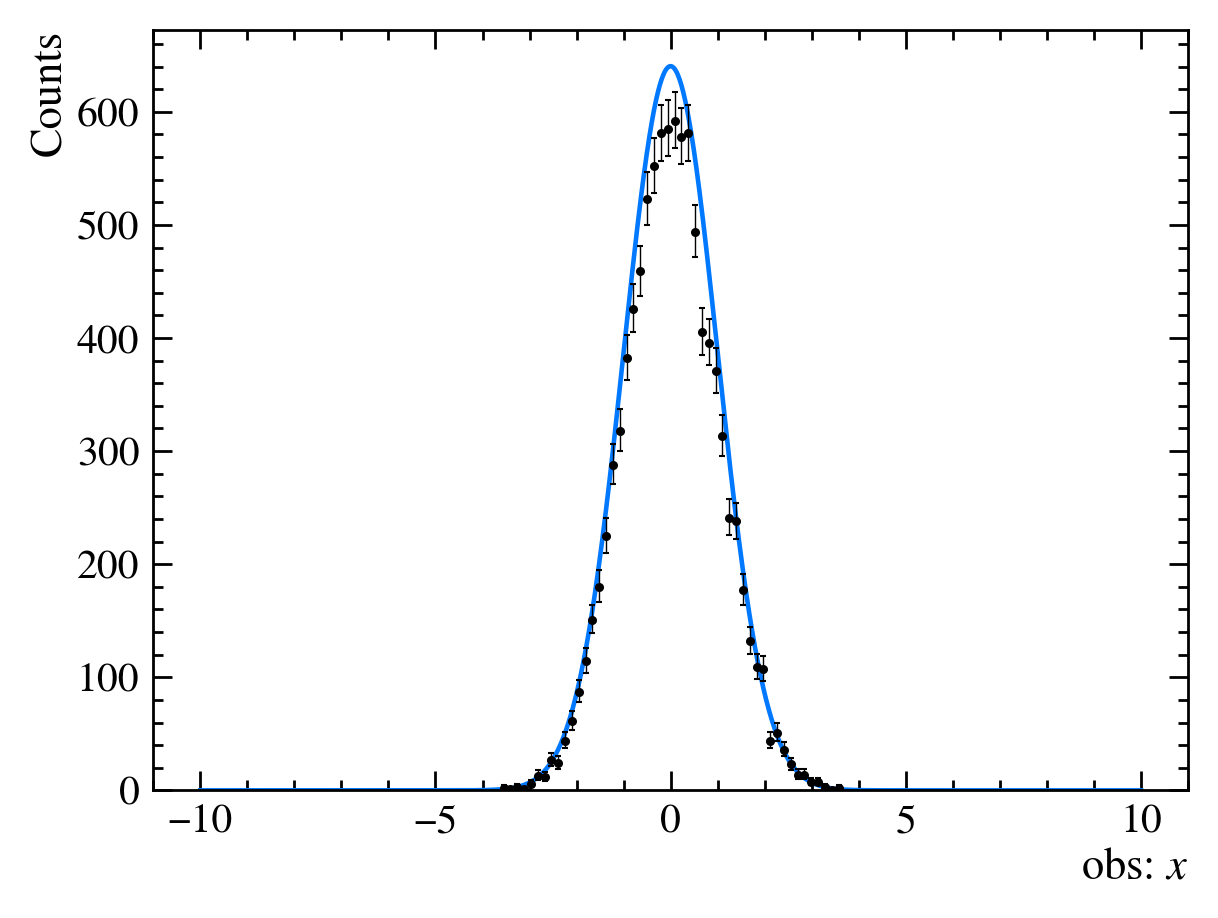

In [8]:
x = np.linspace(-10, 10, 1000)

plt.figure()
#plt.title(title)
y = gauss.pdf(x).numpy()
# y_gauss = (gauss.pdf(x) * frac).numpy()
# y_exp = (exponential.pdf(x) * (1 - frac)).numpy()
plt.plot(x, y * plot_scaling / 2.5, label="Sum - Model") # why 2.5????
# plt.plot(x, y_gauss * plot_scaling, label="Gauss - Signal")
# plt.plot(x, y_exp * plot_scaling, label="Exp - Background")
mplhep.histplot(
    np.histogram(data_np, bins=n_bins),
    yerr=True,
    color="black",
    histtype="errorbar",
)
plt.ylabel("Counts")
plt.xlabel("obs: $x$")

In [9]:
data_np.size

10000

In [10]:
data_np

array([-0.76303824, -0.8796819 , -0.19798898, ..., -0.66972989,
        1.04894611,  0.34055818])

In [11]:
y.sum()

49.95000000000002

In [80]:
def pull_array(data, model, bins, ax_range, poisson=True):
    # get histogram from data
    data_counts, data_bins = np.histogram(data, bins=bins, range=ax_range)
    # get values of model in bin centers
    bins_centers = np.array([0.5*(data_bins[i]+data_bins[i+1]) for i in range(bins)])
    model_exp = model.pdf(bins_centers).numpy()
    # integral of model is 1, need to scale
    n_sample = data.size
    plot_scaling = n_sample / bins * (ax_range[1]-ax_range[0])
    model_exp_counts = model_exp * plot_scaling
    # calculate pulls
    pull = data_counts - model_exp_counts 
    data_err = np.sqrt(data_counts) if poisson else np.sqrt(data_counts) # to be fixed
    for i in range(len(data_err)):
        if data_err[i] == 0: data_err[i] = 1.
    norm_pull = pull / data_err
    return norm_pull, bins_centers
    

Text(0, 1, 'Pull')

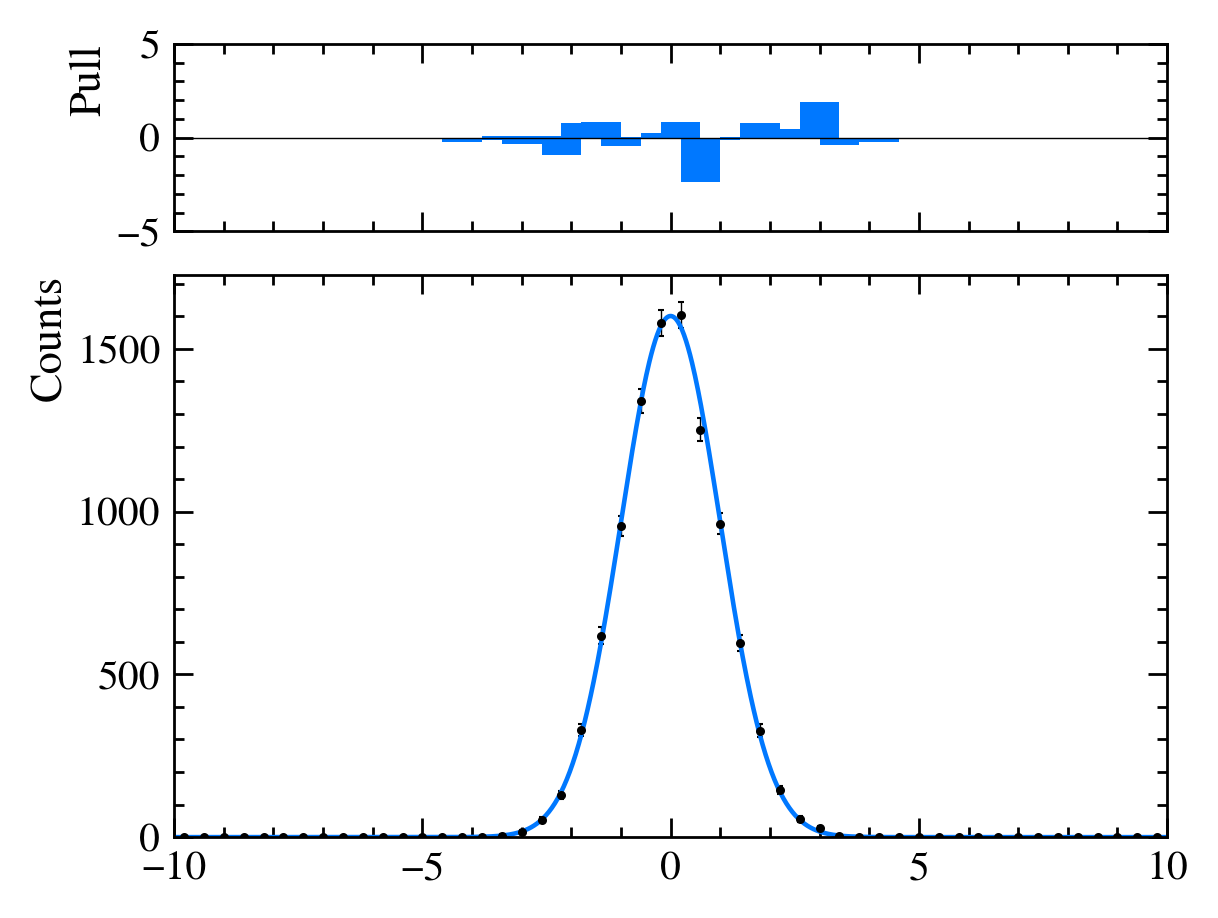

In [88]:
fig = plt.figure()
gs = fig.add_gridspec(ncols=1,nrows=2,height_ratios=[1, 3],hspace=None)
(ax1, ax2) = gs.subplots(sharex='col')
mplhep.histplot(
    np.histogram(data_np, bins=n_bins,range=(-10,10)),
    yerr=True,
    color="black",
    histtype="errorbar",
)
ax2.plot(x, y * plot_scaling, label="Sum - Model")
ax2.set_ylabel('Counts')
pullA, bin_centers = pull_array(data_np, gauss, n_bins, (-10,10))
ax1.set_xlim(-10,10)
ax1.set_ylim(-5,5)
ax1.bar(bin_centers, pullA)#, 'k')
ax1.plot(ax1.get_xlim(),[0,0],'k', lw=1)
ax1.set_ylabel('Pull')

In [25]:
data_counts, data_bins = np.histogram(data_np, bins=n_bins, range=(-10,10))

In [26]:
data_counts

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    1,    5,   16,   54,  130,  328,  619,
        956, 1339, 1580, 1603, 1251,  963,  596,  327,  145,   55,   27,
          4,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

In [27]:
data_bins

array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
        -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
        -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
         0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,   3.6,   4. ,
         4.4,   4.8,   5.2,   5.6,   6. ,   6.4,   6.8,   7.2,   7.6,
         8. ,   8.4,   8.8,   9.2,   9.6,  10. ])

In [28]:
bins_centers = np.array([0.5*(data_bins[i]+data_bins[i+1]) for i in range(len(data_bins)-1)])

In [29]:
bins_centers

array([-9.8, -9.4, -9. , -8.6, -8.2, -7.8, -7.4, -7. , -6.6, -6.2, -5.8,
       -5.4, -5. , -4.6, -4.2, -3.8, -3.4, -3. , -2.6, -2.2, -1.8, -1.4,
       -1. , -0.6, -0.2,  0.2,  0.6,  1. ,  1.4,  1.8,  2.2,  2.6,  3. ,
        3.4,  3.8,  4.2,  4.6,  5. ,  5.4,  5.8,  6.2,  6.6,  7. ,  7.4,
        7.8,  8.2,  8.6,  9. ,  9.4,  9.8])

In [41]:
n_sample = data_np.size
plot_scaling = n_sample / n_bins * obs.area()

In [57]:
np.linspace(-10,10,10)

array([-10.        ,  -7.77777778,  -5.55555556,  -3.33333333,
        -1.11111111,   1.11111111,   3.33333333,   5.55555556,
         7.77777778,  10.        ])

In [59]:
np.linspace(0,9,10)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [84]:
ax1.get_xlim()

(-11.22, 11.22)